In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize

#potentiall remove at some point
import pickle
import pandas as pd
from tqdm import tqdm

# Global parameters

In [4]:
# global parameters
dt=1

# Implementation of measures

### 1. Find smallest $h$ for which the overlap with the zero-input case is less than discrimination error $\varepsilon$
Note: $a(0)=0$ for all $\lambda$ and $\mu$ such that $P(o)=\mathcal{N}(0,\sigma)$

In [83]:
def calc_overlap(pmf1, pmf2):
    """
    calculates the overlap between two discrete probability mass functions
    ATTENTION: needs user to ensure that domains are identical!
    """
    assert len(pmf1) == len(pmf2)
    return np.sum(np.minimum(pmf1, pmf2)) * 0.5


def find_discriminable_inputs(pmf, h_range, epsilon:float, start="left"):
    """
    Determine all inputs h in range h_range such that the overlap between all pmfs is less than epsilon
    The pmfs of h_range[0] and h_range[1] sever as boundaries

    # Parameter
    - pmf: function
    - h_range: array-like with length two
    - epsilon: float
        discrimination error that specifies maximal overlap between two probability mass functions
    """
    assert len(h_range) == 2
    h_left, h_right = h_range
    hs = []
    if start == "left":
        h_ref = h_left
        pmf_end = pmf(h_right)
    elif start == "right":
        h_ref = h_right
        pmf_end = pmf(h_left)
    pmf_ref = pmf(h_ref)

    while True:
        def func(h):
            return calc_overlap(pmf_ref, pmf(h)) - epsilon

        try:
            if start == "left":
                h_new = optimize.bisect(func, h_ref, h_right)
            elif start == "right":
                h_new = optimize.bisect(func, h_left, h_ref)
            pmf_new = pmf(h_new)
            if calc_overlap(pmf_end, pmf_new) < epsilon:
                hs.append(h_new)
                h_ref = h_new
                pmf_ref = pmf_new
            else:
                break
        except:
            break
    return hs


def dynamic_range(h_range):
    """
    Calculate the dynamic range from the range h_range
    """
    assert len(h_range) == 2
    h_left, h_right = h_range
    return 10 * (np.log10(h_right) - np.log10(h_left))

[2.1417125850575758e-06, 4.475133147939388e-06, 7.0271877041913165e-06, 9.830099365027546e-06, 1.292278455365664e-05, 1.6352654230904953e-05, 2.0178004871218804e-05, 2.4471393540214132e-05, 2.932435234506229e-05, 3.485393253207265e-05, 4.121220444148589e-05, 4.860049678134831e-05, 5.7291217390687155e-05, 6.766212626106614e-05, 8.025251458484432e-05, 9.586014052295432e-05, 0.00011571740822583842, 0.00014183367168647698, 0.00017772150862782938, 0.00023012677765333586, 0.00031386200822867543, 0.00046900312700404385, 0.0008547758157241656]
[0.0011665105592584268, 0.000558441780965792, 0.0003556691416325555, 0.000254266768972282, 0.00019342100264946045, 0.00015285522084719955, 0.00012387855422804799, 0.0001021453303941169, 8.524152935478934e-05, 7.171832688713568e-05, 6.065371803425491e-05, 5.1433041759984604e-05, 4.363092881155604e-05, 3.69433755269218e-05, 3.114744366430009e-05, 2.6075933916815827e-05, 2.1601084920702437e-05, 1.762343996907725e-05, 1.4064470062092011e-05, 1.08613582146633

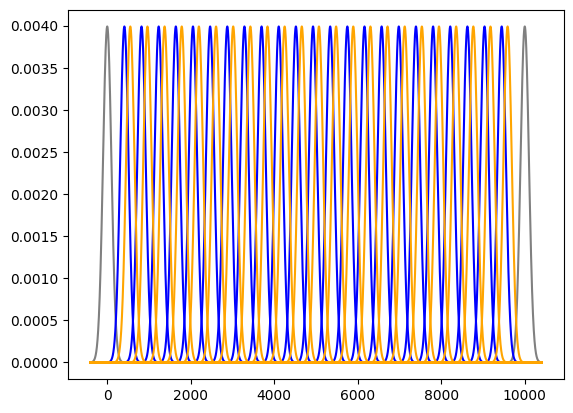

In [84]:
# test discriminable intervals
N = int(1e4)
mu = 0.2
lam = 0.99999
sigma=1e-2
Xs = np.arange(-4*sigma*N,N+4*sigma*N)
epsilon=0.02

def pmf(h):
    # see below for formal derivation, here just as a test
    A = mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt)) * N
    # in domain with delta = 1
    delta = 1
    return stats.norm.pdf(Xs, A, sigma*N)*delta

h_range=[0,1e3]
pmf_ref_left = pmf(h_range[0])
pmf_ref_right = pmf(h_range[1])

plt.plot(Xs,pmf_ref_left, color="gray")
plt.plot(Xs,pmf_ref_right, color="gray")

hs_left = find_discriminable_inputs(pmf,h_range, epsilon, start="left")
print(hs_left)
for h in hs_left:
    plt.plot(Xs,pmf(h), color="blue")

hs_right = find_discriminable_inputs(pmf,h_range, epsilon, start="right")
print(hs_right)
for h in hs_right:
    plt.plot(Xs,pmf(h), color="orange")
#plt.legend()

# Consider network output with Gaussian noise
The output of the network is the sum of the network activity and Gaussian noise $\eta\sim\mathcal{N}(0,1)$ such that 
$$ o = a + \sigma\eta $$
The output is thus a convolution between $P(a)$ and $\mathcal{N}(0,\sigma)$.

For $T\to\infty$ the distribution of activity is a delta-distribution such that the the output distribution becomes a shifted Gaussian
$$ P(o) = \mathcal{N}(a(h|\lambda,\mu), \sigma)$$

# Analytic solution for $T\to\infty$
For the $T\to\infty$ case, we have a one-to-one mapping between input $h$ and network activity $a$, given by 
$$a(h|\lambda, \mu) = \frac{\mu\left(1-e^{-h\Delta t}\right)}{1-\lambda(1-\mu)-\lambda\mu e^{-h\Delta t}}$$

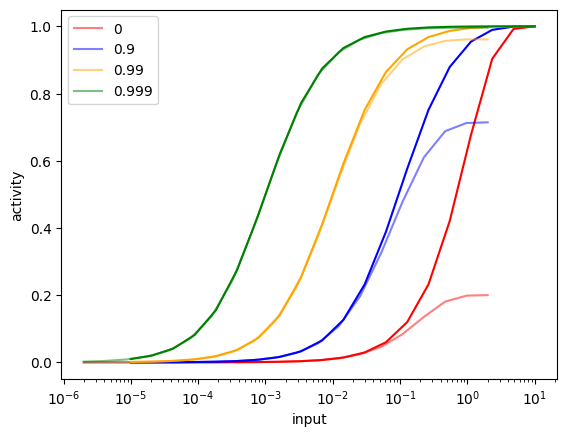

In [85]:
def a(h,lam,mu, dt=1):
    """
        mean steady state activity per neuron in recurrent network with largest eigenvalue lam where a fraction of mu neurons receives input h
    """
    return mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt))

hs=np.logspace(-5,1,20)
colors=['red','blue','orange','green']
for i,lam in enumerate([0,0.9,0.99,0.999]):
    plt.plot(hs*0.2, a(hs, lam, 0.2), label='{}'.format(lam), color=colors[i], alpha=0.5)
    plt.plot(hs, a(hs, lam, 1.0), color=colors[i])
plt.xscale("log")
plt.xlabel("input")
plt.ylabel("activity")
plt.legend()

100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


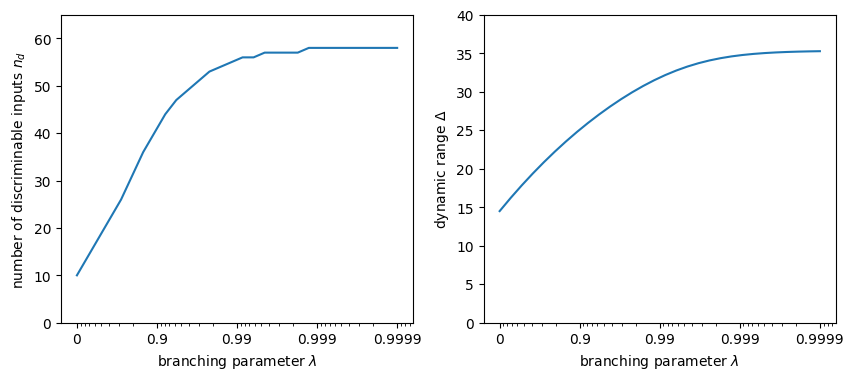

In [86]:
# network parameters
N = int(1e4)
mu = 0.2
sigma = 1e-2
Xs = np.arange(-4 * sigma * N, N + 4 * sigma * N)
epsilon = 0.2
lams = 1 - np.logspace(-4, 0, 30)

# analysis parameters
drs_inf = np.zeros(len(lams))
nds_inf = np.zeros(len(lams))
h_range = [0, 1e3]
# attempt to match previous data analysis
logh = np.arange(-7, 1.5, 0.05)  # 170 elements
for i, lam in tqdm(enumerate(lams), total=len(lams)):
    # distribution of noisy output
    def pmf_o_given_h(h):
        A = a(h, lam, mu) * N
        return stats.norm.pdf(Xs, A, sigma * N)

    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, epsilon, start="right")
    drs_inf[i] = dynamic_range((hs_left[0], hs_right[0]))
    nds_inf[i] = 0.5 * (len(hs_left) + len(hs_right))

# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams, nds_inf)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams, drs_inf)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

# Analysis of data

In [5]:
path_beta_params='../data/betaParams/subpop_k=100'
sub_typ = "Full"

# get unique epsilon values from the filenames in the directory
import os
filenames = os.listdir(path_beta_params)
print(filenames)
# select only files that match "*subFull*"
filenames = [f for f in filenames if sub_typ in f]
print(filenames)
# get epsilon values from filenames
all_epsilons = [float(f.split("_")[0].split("=")[-1]) for f in filenames]
print(all_epsilons)
# get unique epsilon values
list_epsilons = np.unique(all_epsilons)
print(list_epsilons)
# get all windows from filenames
all_windows = [int(f.split("_")[2].split("=")[-1]) for f in filenames]
print(all_windows)
# get unique windows
list_windows = np.unique(all_windows)
print(list_windows)

def filename(path, epsilon, sub_typ, window, realization):
    return os.path.join(path, "epsilon={:.2e}_sub{:s}_window={:d}_realization={:d}.pkl".format(epsilon, sub_typ, window, realization))

def load_beta_params(filename):
    with open(filename, 'rb') as f:
        beta_params = pickle.load(f)
    return beta_params

# show example of keys in the beta files
beta = load_beta_params(filename(path_beta_params, list_epsilons[0], sub_typ, list_windows[0], 0))
print("keys:", beta.keys())

['epsilon=3.16e-03_subFull_window=1_realization=3.pkl', 'epsilon=1.00e-01_subRandom_window=10_realization=5.pkl', 'epsilon=1.00e-02_subFix_window=100_realization=8.pkl', 'epsilon=1.00e-01_subFull_window=1_realization=4.pkl', 'epsilon=1.00e+00_subFull_window=10_realization=3.pkl', 'epsilon=1.00e-02_subRandom_window=10_realization=4.pkl', 'epsilon=3.16e-02_subFix_window=1_realization=0.pkl', 'epsilon=3.16e-02_subRandom_window=1000_realization=9.pkl', 'epsilon=3.16e-01_subRandom_window=1_realization=4.pkl', 'epsilon=1.00e-03_subFull_window=10_realization=7.pkl', 'epsilon=1.00e+00_subFull_window=1000_realization=0.pkl', 'epsilon=3.16e-01_subFix_window=100_realization=7.pkl', 'epsilon=3.16e-02_subRandom_window=10000_realization=5.pkl', 'epsilon=3.16e-03_subRandom_window=10_realization=7.pkl', 'epsilon=1.00e-02_subFull_window=100_realization=4.pkl', 'epsilon=1.00e-04_subFull_window=100_realization=3.pkl', 'epsilon=3.16e-02_subFix_window=100_realization=1.pkl', 'epsilon=1.00e-04_subRandom_win

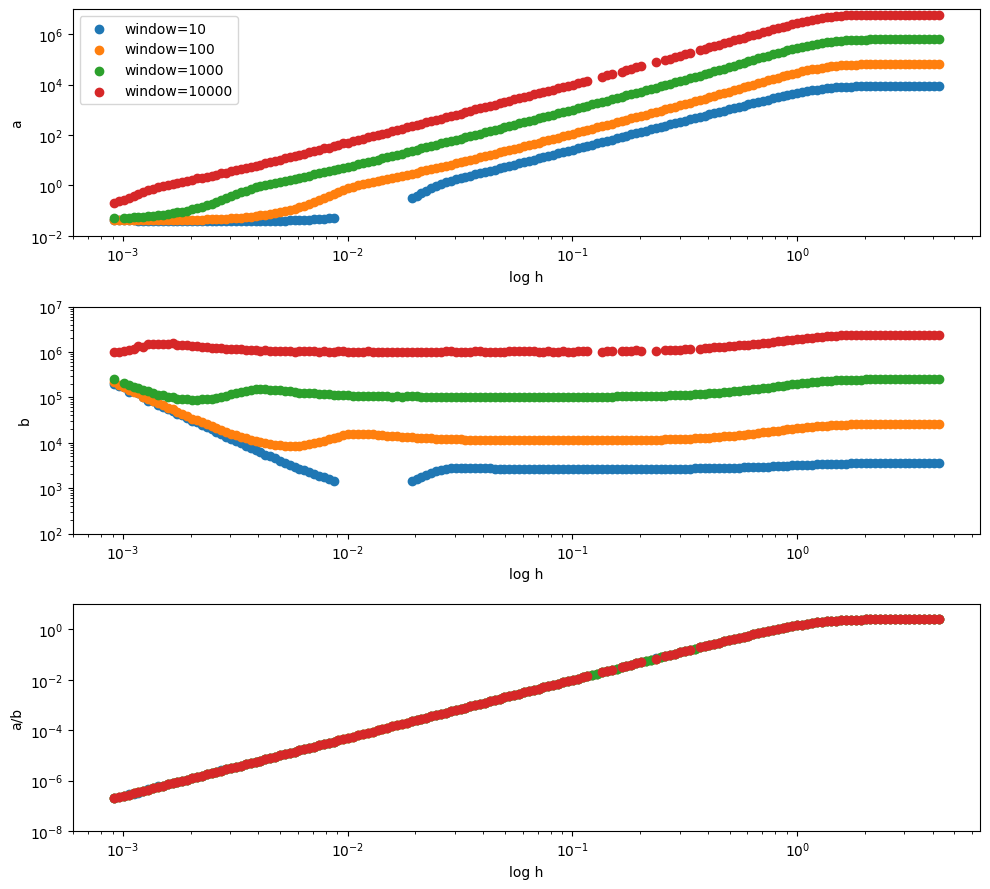

In [18]:
realization=3
list_windows = [10, 100, 1000, 10000]

# plot beta parameters for different values of epsilon in two parallel subplots (a and b)
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
epsilon = 0.1
for window in list_windows[::-1]:
    beta_params = load_beta_params(filename(path_beta_params, epsilon, sub_typ, window, realization))
    # filter out invalid values (a,b < 0)
    mask = (beta_params['a'] > 0) & (beta_params['b'] > 0)
    hs = np.exp(beta_params['logh'][mask])
    valas = beta_params['a'][mask]
    valbs = beta_params['b'][mask]
    #plot
    axes[0].scatter(hs, valas, label='window={}'.format(window))    
    axes[1].scatter(hs, valbs )    
    axes[2].scatter(hs, valas/valbs)    

axes[0].set_xlabel("log h")
axes[1].set_xlabel("log h")
axes[2].set_xlabel("log h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")
axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")
axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")
axes[0].legend(loc='upper left')

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e2, 1e7)
axes[2].set_ylim(1e-8, 1e1)
plt.tight_layout()

Fit the available data with a deep neural network that maps system parameters (h,epsilon) to beta-distribution parameters (a,b)

In [89]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [90]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
# load data
x_data = []
y_data = []

def get_data(realization, epsilons=list_epsilons, shuffle=1234):
    X1, X2 = np.empty(shape=(0,)), np.empty(shape=(0,))
    Y1, Y2 = np.empty(shape=(0,)), np.empty(shape=(0,))
    for epsilon in epsilons:
        beta_params = load_beta_params(filename(path_beta_params, epsilon, sub_typ, window, realization))
        # filter out invalid values where either a or b are negative
        mask = (beta_params['a'] > 0) & (beta_params['b'] > 0)
        loghs = beta_params['logh'][mask]
        loges = np.log(epsilon) * np.ones_like(loghs)
        logas = np.log(beta_params['a'][mask])
        logbs = np.log(beta_params['b'][mask])
        X1 = np.append(X1, loghs)
        X2 = np.append(X2, loges)
        Y1 = np.append(Y1, logas)
        Y2 = np.append(Y2, logbs)
    # shuffle with random mask
    mask = np.arange(len(X1))
    # if shuffle is not False:
    if shuffle is not None:
        np.random.seed(shuffle)
        np.random.shuffle(mask)
    x_data = np.stack((X1[mask], X2[mask]), axis=1)
    y_data = np.stack((Y1[mask], Y2[mask]), axis=1)
    print(realization, x_data.shape, y_data.shape)
    return x_data, y_data, 
get_data(realization, shuffle=None)

1 (1346, 2) (1346, 2)


(array([[-7.        , -9.21034037],
        [-6.95      , -9.21034037],
        [-6.9       , -9.21034037],
        ...,
        [ 1.35      ,  0.        ],
        [ 1.4       ,  0.        ],
        [ 1.45      ,  0.        ]]),
 array([[-3.45691289,  4.44549594],
        [-3.37672045,  6.94768195],
        [-3.36084395,  7.41968345],
        ...,
        [67.38807008, 68.77436444],
        [67.38807008, 68.77436444],
        [67.38807008, 68.77436444]]))

We follow here the [simple example](https://notebook.community/kit-cel/lecture-examples/mloc/ch3_Deep_Learning/pytorch/function_approximation_with_MLP) using pytorch

Define the model

TODO: In principle we know the $h->0$ and $h->\infty$ solution from the $T->\infty$ solution. Can we make use of this?

1 (1346, 2) (1346, 2)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:30<00:00, 328.43it/s]


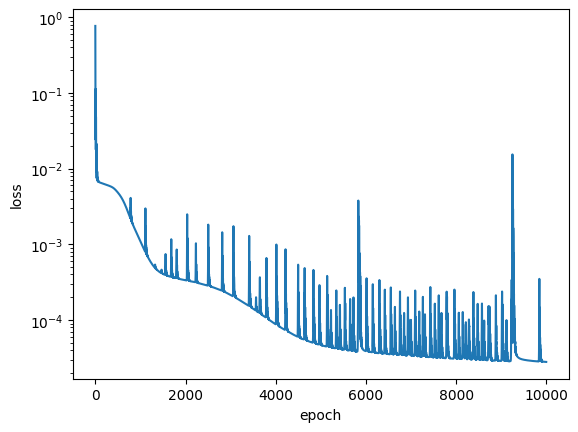

In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, 42)
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(42, 42)
        self.act2 = nn.Tanh()
        self.hidden3 = nn.Linear(42, 42)
        self.act3 = nn.Tanh()
        self.output = nn.Linear(42, 2)
        #self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.output(x)
        return x
 

def train_model_simple(X_train, Y_train, epochs):
    """
    Trains a simple neural network with one hidden layer with units neurons
    """
    # prepare data
    X_train_tensor = torch.from_numpy(X_train).float()
    Y_train_tensor = torch.from_numpy(Y_train).float()

    # create model
    model = NeuralNetwork()

    # Adam and MSE Loss
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop    
    history_loss = []
    for epoch in tqdm(range(epochs)):
        yhat = model(X_train_tensor)
        loss = loss_fn(yhat, Y_train_tensor)
        history_loss.append(loss.item())
        # compute gradients
        loss.backward() 
        # carry out one optimization step with Adam
        optimizer.step()   
        # reset gradients to zero
        optimizer.zero_grad()

    return model, history_loss

# rescale data (can use the same scaler multiple times using fit_transform function)
X_scaler = MinMaxScaler(feature_range=(-1, 1))
Y_scaler = MinMaxScaler(feature_range=(-1, 1))
X, Y = get_data(realization)
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

# train model
model, loss = train_model_simple(X_scaled, Y_scaled, 10000)
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()


In [1]:
import itertools
import matplotlib.pyplot as plt
#compare to data
X, Y = get_data(0, shuffle=None)
# mesh grid for contour plot
loghs = np.linspace(-7, 1.5, 170)

# compare to data
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
X,Y = get_data(0, shuffle=None)

for epsilon in list_epsilon:
    # plot data
    mask = np.fabs(X[:,1] - np.log(epsilon)) < 1e-3
    print(epsilon, np.sum(mask))
    ref = axes[0].scatter(np.exp(X[mask,0]), np.exp(Y[mask, 0]), label='lambda={}'.format(1-epsilon))
    color = ref.get_facecolor()[0]
    axes[1].scatter(np.exp(X[mask,0]), np.exp(Y[mask, 1]), label='epsilon={}'.format(epsilon), color=color)
    axes[2].scatter(np.exp(X[mask,0]), np.exp(Y[mask, 0])/np.exp(Y[mask, 1]), label='epsilon={}'.format(epsilon), color=color)
    print(epsilon, X[-1,0], np.exp(Y[-1, 0]), np.exp(Y[-1, 1]))
    # plot model
    loges = np.log(epsilon) * np.ones_like(loghs)
    X_model = np.stack((loghs, loges), axis=1)
    X_model_scaled = X_scaler.transform(X_model)
    Y_model_scaled = model(torch.from_numpy(X_model_scaled).float()).detach().numpy()
    Y_model = Y_scaler.inverse_transform(Y_model_scaled)
    axes[0].plot(np.exp(loghs), np.exp(Y_model[:, 0]), color=color)
    axes[1].plot(np.exp(loghs), np.exp(Y_model[:, 1]), color=color)
    axes[2].plot(np.exp(loghs), np.exp(Y_model[:, 0])/np.exp(Y_model[:, 1]), color=color)

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")
axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")
axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")
axes[0].legend(loc='upper left')
plt.tight_layout()


NameError: name 'get_data' is not defined

### Convolution of beta distribution with Guassian 

In [126]:
N = 1e4
delta = 1/N
sigma=1e-2

support = np.arange(0, 1+4*sigma, delta)
support = np.concatenate((-support[::-1], support[1:]))

def pmf(h, epsilon, verbose=False):
    # distribution is given by Beta-distribution specified by a and b
    X = np.log(np.array([h,epsilon]))
    X_scaled = X_scaler.transform(X.reshape(-1,1).T)
    Y_scaled = model(torch.from_numpy(X_scaled).float()).detach().numpy()
    loga,logb = Y_scaler.inverse_transform(Y_scaled).T.reshape(-1)
    a,b = np.exp(loga), np.exp(logb)
    pmf_beta = stats.beta.pdf(support, a, b)*delta
    # check for special cases with vanishing pmf
    if np.sum(pmf_beta) < 0.5:
        print(f'ERROR: (a,b)=({a},{b}) vanishing beta distribution with sum(pmf)={np.sum(pmf_beta)}')
    # check for special cases that result in delta distribution (find any pmf_beta to be infinity)
    if np.any(pmf_beta==np.inf):
        if verbose:
            print(f'WARNING: (a,b)=({a},{b}) infinity encountered in beta distribution, converted to pmf with single probable state')
        mask = pmf_beta==np.inf
        pmf_beta[mask] = 1
        pmf_beta[~mask] = 0
        if np.sum(pmf_beta) != 1:
            print("ERROR: pmf not normalized to 1")
    pmf_norm = stats.norm.pdf(support, 0, sigma)*delta
    # convolution with a Gaussian distribution at every point of the support
    return np.convolve(pmf_beta, pmf_norm, mode="same")

0.0 -7.0 -1.0 -1.0
0.0 -6.150000000000003 0.04222455474724198 299450.4147489856
0.0 -5.300000000000006 0.039245043507023555 38862.70036435076
0.0 -4.450000000000009 -1.0 -1.0
0.0 -3.600000000000012 -1.0 -1.0
0.0 -2.750000000000015 -1.0 -1.0
0.0 -1.9000000000000181 24.580009521400154 9798.77364858321
0.0 -1.0500000000000211 182.61673459995603 10525.6902491465
0.0 -0.20000000000002413 1594.7931660543295 15446.37705990786
0.0 0.6499999999999728 138138.27598632406 560576.2317936963
0.9 -7.0 0.04152615959638696 204008.5068283293
0.9 -6.150000000000003 0.03855827794919424 27765.385022581933
0.9 -5.300000000000006 0.03704684580139214 3708.496435303882
0.9 -4.450000000000009 -1.0 -1.0
0.9 -3.600000000000012 -1.0 -1.0
0.9 -2.750000000000015 6.686997341105555 1879.1014963295697
0.9 -1.9000000000000181 47.76373720559413 1904.8755312536198
0.9 -1.0500000000000211 326.22763232102017 1880.6154292760175
0.9 -0.20000000000002413 1786.7941030129261 1730.6474452150524
0.9 0.6499999999999728 3798.6906281

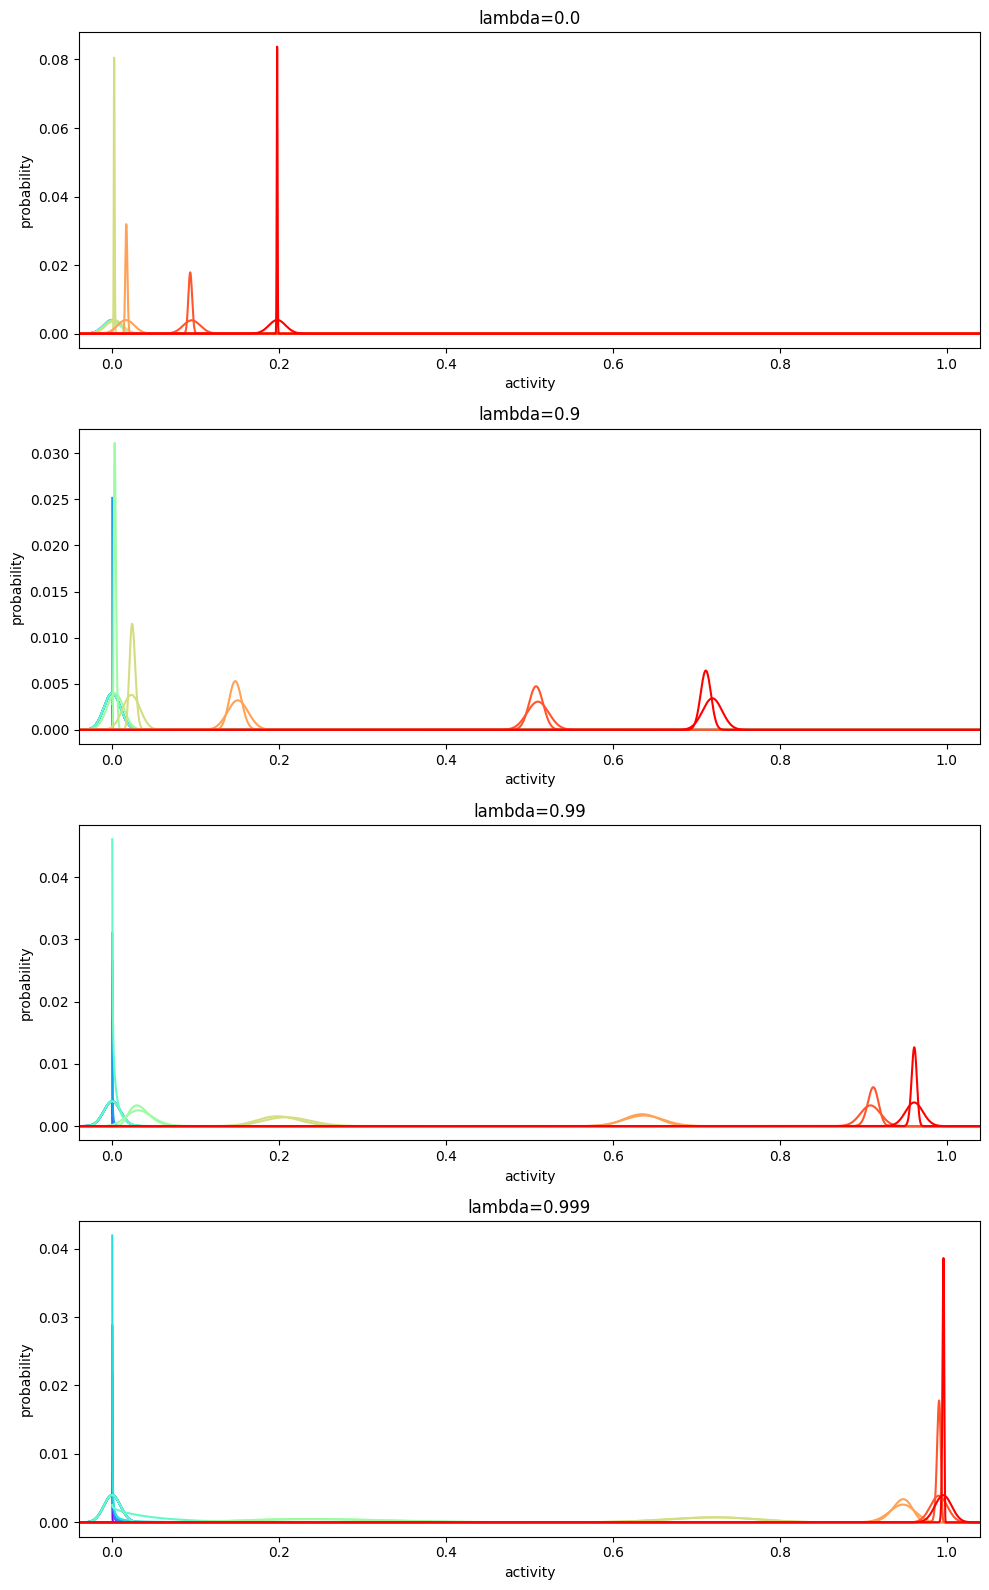

In [157]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.9, 0.99, 0.999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(10, 4*len(list_lam)))

list_hs = np.logspace(-3,2,10)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    beta_params = load_beta_params(filename(path_beta_params, 1-lam, sub_typ, window, realization))
    list_loghs = beta_params['logh'][::17]
    for logh in list_loghs:
        c = next(color)
        # from data as closest match 
        beta_h = beta_h = beta_params.loc[ beta_params['logh'] == logh ]
        a,b = beta_h['a'].values[0], beta_h['b'].values[0]
        pmf_beta = stats.beta.pdf(support, a, b)*delta
        axes[i].plot(support, pmf_beta, color=c)
        print(lam, logh, a, b)
        # from ML
        pmf_ml = pmf(np.exp(logh), 1-lam)
        axes[i].plot(support, pmf_ml, color=c)
        axes[i].set_xlim(0-4*sigma,1+4*sigma)
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
plt.tight_layout()


From the interpolation model we can obtain estimates of the dynamic range and the resolution

Important: Need to be able to specify reference distributions! Else we cannot parse no/full activity for simulations. Reference could come from infinite-T solution plus Gaussian!

hs_left:  [0.5306754280829171, 0.756685570894673, 0.9817664872778001]
hs_right:  [1.2123958502980992, 0.9361260472015809, 0.7154265559448761]


(-0.04, 1.04)

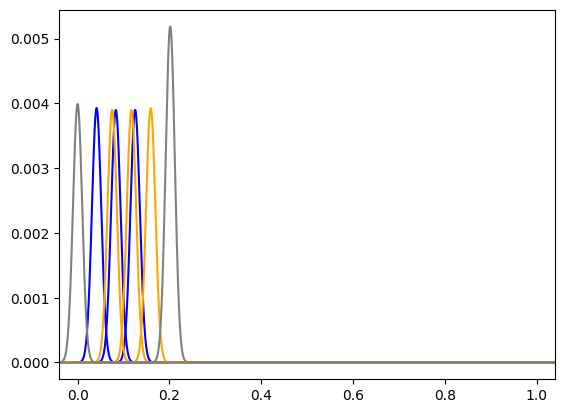

In [158]:
# test discriminable intervals
lam = 0.0
def _pmf(h):
    return pmf(h, 1-lam)

# need delta 1/N to be consistent with the overlap error that is defined on the level of the pmf with activity unit of neurons?
epsilon=0.02

# has to be in range of data! (lam=0 there is sth odd with the data fit?)
h_range=[np.exp(-7),np.exp(1)]
pdf_ref_left = _pmf(h_range[0])
pdf_ref_right = _pmf(h_range[-1])

hs_left = find_discriminable_inputs(_pmf, h_range, epsilon, start="left")
print("hs_left: ", hs_left)
for h in hs_left:
    plt.plot(support, _pmf(h), color="blue")

hs_right = find_discriminable_inputs(_pmf, h_range, epsilon, start="right")
print("hs_right: ", hs_right)
for h in hs_right:
    plt.plot(support, _pmf(h), color="orange")

plt.plot(support, pdf_ref_left, color="gray")
plt.plot(support, pdf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)

# plt.legend()

In [ ]:
lamdas = 1 - np.logspace(-4, 0, 30)
# this is the error threshold
epsilon=0.02

# analysis parameters
drs = np.zeros(len(epsilons))
nds = np.zeros(len(epsilons))
mis = np.zeros(len(epsilons))

# need to exclude the zero here because of logh fit
h_range=[np.exp(-7), np.exp(1)]

def pmf(h, epsilon):
    # distribution is given by Beta-distribution specified by a and b
    X = np.log(np.array([h,epsilon]))
    X_scaled = X_scaler.transform(X.reshape(-1,1).T)
    Y_scaled = model(torch.from_numpy(X_scaled).float()).detach().numpy()
    loga,logb = Y_scaler.inverse_transform(Y_scaled).T.reshape(-1)
    a,b = np.exp(loga), np.exp(logb)
    pmf_beta = stats.beta.pdf(support, a, b)*delta
    # check for special cases that result in delta distribution (find any pmf_beta to be infinity)
    if np.any(pmf_beta==np.inf):
        #TODO: it appears that the same pmf is created multiple times in the algorithm ... why? can we precompute and store?
        print(f'WARNING: (a,b)=({a},{b}) infinity encountered in beta distribution, converted to pmf with single probable state')
        mask = pmf_beta==np.inf
        pmf_beta[mask] = 1
        pmf_beta[~mask] = 0
        if np.sum(pmf_beta) != 1:
            print("ERROR: pmf not normalized to 1")
            exit()
    pmf_norm = stats.norm.pdf(support, 0, sigma)*delta
    # convolution with a Gaussian distribution at every point of the support
    return np.convolve(pmf_beta, pmf_norm, mode="same")

for i, lam in enumerate(lamdas):
    print(i,1-lam)
    # distribution is given by Beta-distribution specified by a and b
    def pmf_o_given_h(h):
        return pmf(h,1-lam)
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, epsilon, start="right")
    print(hs_left,hs_right)
    if len(hs_left) > 0 and len(hs_right) > 0:
        drs[i] = dynamic_range((hs_left[0], hs_right[0]))
        nds[i] = 0.5 * (len(hs_left) + len(hs_right))
    else:
        drs[i] = 0
        nds[i] = 0
    
    



0 9.999999999998899e-05
[0.02900534211811577] [0.0749736077625846]
1 0.00013738237958837995
[0.030158987013169186] [0.10149768445849634]
2 0.00018873918221351538
[0.03144707188735836, 0.10531830709260243] [0.1322220447913337, 0.043509820766246946]
3 0.0002592943797404823
[0.03290883299226043, 0.09865947472490609] [0.16619057159886036, 0.06683350864674661]
4 0.0003562247890261938
[0.03458642747142503, 0.09466440367002289, 0.20210568363377832] [0.20347756884316326, 0.09533802631854008, 0.035036569046216]
5 0.0004893900918477856
[0.03652577391111423, 0.09256993951551348, 0.1792958660518006] [0.2449086727804119, 0.1279015625000743, 0.060755956024925645]
6 0.0006723357536498886
[0.038778906734315464, 0.09189177053952241, 0.16531110183959036] [0.29184901910206973, 0.16423154847597146, 0.09117766096439954]
7 0.0009236708571873642
[0.041406406292424654, 0.0923336961092229, 0.15676702606532295, 0.25500621425191944] [0.3415239585691574, 0.20285233246881118, 0.12418823428313887, 0.067644439121714

0 9.999999999998899e-05


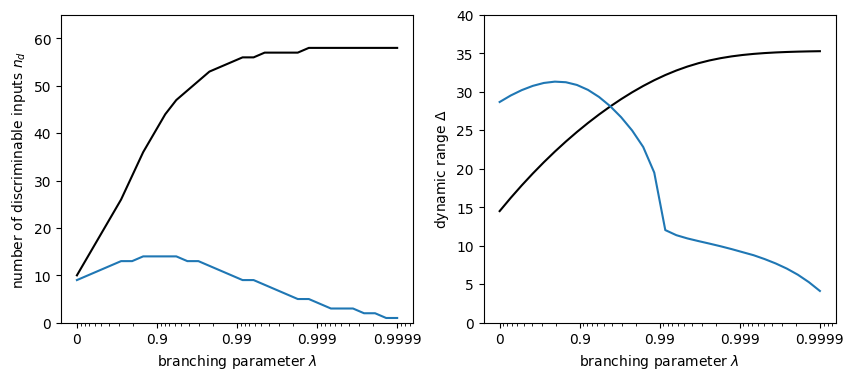

In [ ]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams, nds_inf, label="inf", color="black")
ax[0].plot(1 - lams, nds)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams, drs_inf, label="inf", color="black")
ax[1].plot(1 - lams, drs)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

## TODO:
- Develop an approximation to the finite-time solution as a correction to the infinite T limit?
- Fit this?
- Or take absolute maximum? -> as inset?
- Only Fig n_d and DR ... Lets try to replot with development of maxima as inset
